# Plain English description

Here we explain the contents of this notebook for a non-coding audience, breaking down each part of the process according to our 5-step machine learning roadmap (described in the main text of the paper). <br>

### (1) Identify the materials question of interest
The question here is how to forecast long-term degradation in MAPI solar cells under environmental stress (in this case, temperature). 

### (2) Obtain sufficient data for model training
We use data from the publication: Holzhey, P., et al. A chain is as strong as its weakest link – Stability study of MAPbI3 under light and temperature. Materials Today 29, 10-19, doi:10.1016/j.mattod.2018.10.017 (2019). The authors track solar cell power output over a long time frame (500 hours) for cells held at five different temperatures (-10, 20, 50, 65, and 95C).

### (3) Data pre-processing
Information about the raw data: <br>
 - In total: five 500-hour runs on MAPI solar cell samples, with the temperature held constant throughout each run. Each time-series data point contains the time (in hours) and device power. <br>
 
The pre-processing steps are as follows: <br>
 - Create a pandas dataframe and load the data <br>
 - Clean the data files (cut to equal duration) and resample such that data points are 60 seconds apart <br>
 - Normalize the power data <br>
 - Hold out one entire experimental data file (at 50C) and set aside for testing <br>
 - Augment the data using a linear interpolation method. Essentially, this creates several "intermediate" temperature-power runs that are weighted linear combinations of the experimental runs. This routine thus does not introduce any data points outside of the bounds of the raw data, and does not include the held out data file. After augmentation, the data set consists of 11000 time-series data points. <br>
 - Randomly stitch together the runs, one after another, to create a single (much longer) time-series. <br>
 - Split the stitched-together time series into 70% training and 30% validation sets 

### (4) Feature engineering
We do not use feature engineering in this case. 

### (5) Model optimization and testing
A long short-term memory (LSTM) model is constructed constructed and trained using the keras deep learning framework. The network architecture consists of:
 - Five input units <br>
 - A leaky rectified linear unit (ReLU) as the activation function <br>
 - A dropout layer to mitigate overfitting <br>
 - A dense layer to output the prediction <br>
Interested readers can find more information about each of these layers at https://www.tensorflow.org/api_docs/python/tf/keras/layers <br>

The LSTM is trained over the course of 200 epochs, where each epoch invovles stepping through all of the training and validation data. Finally, the model is evaluated on the unseen test set: the experimental run at 50C that was held our prior to data augmentation and training. The LSTM predicts the entire 500 hour time-series with an NRMSE of only 5.5%.

# Import the required packages

In [1]:
from collections import OrderedDict
from glob import glob
from datetime import datetime, timedelta
import string
import os
import itertools
import random

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
from matplotlib import ticker

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, r2_score

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM, LSTM, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
import keras.backend as K

import mlflow
import mlflow.keras
import tensorflow as tf

warnings.filterwarnings('ignore')

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

plot_font_dict = {'fontname':'Arial'}

def NRMSE(yhat, y):
    num = np.sqrt(np.mean((yhat.flatten() - y.flatten())**2))
    den = np.mean(y)
    return num / den

def k_NRMSE(y_true, y_pred):
    num = K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
    num = tf.cast(num, tf.float32)
    
    den = K.max(y) - K.min(y)
    den = tf.cast(den, tf.float32)
    
    return (num / den) * 100

def normalize_data(data, max_bound=1, min_bound=-1):
    return (max_bound - min_bound) * (data - min(data)) / (max(data) - min(data)) + min_bound

Using TensorFlow backend.


# Raw data

Text(0.5, 0, 'Time (h)')

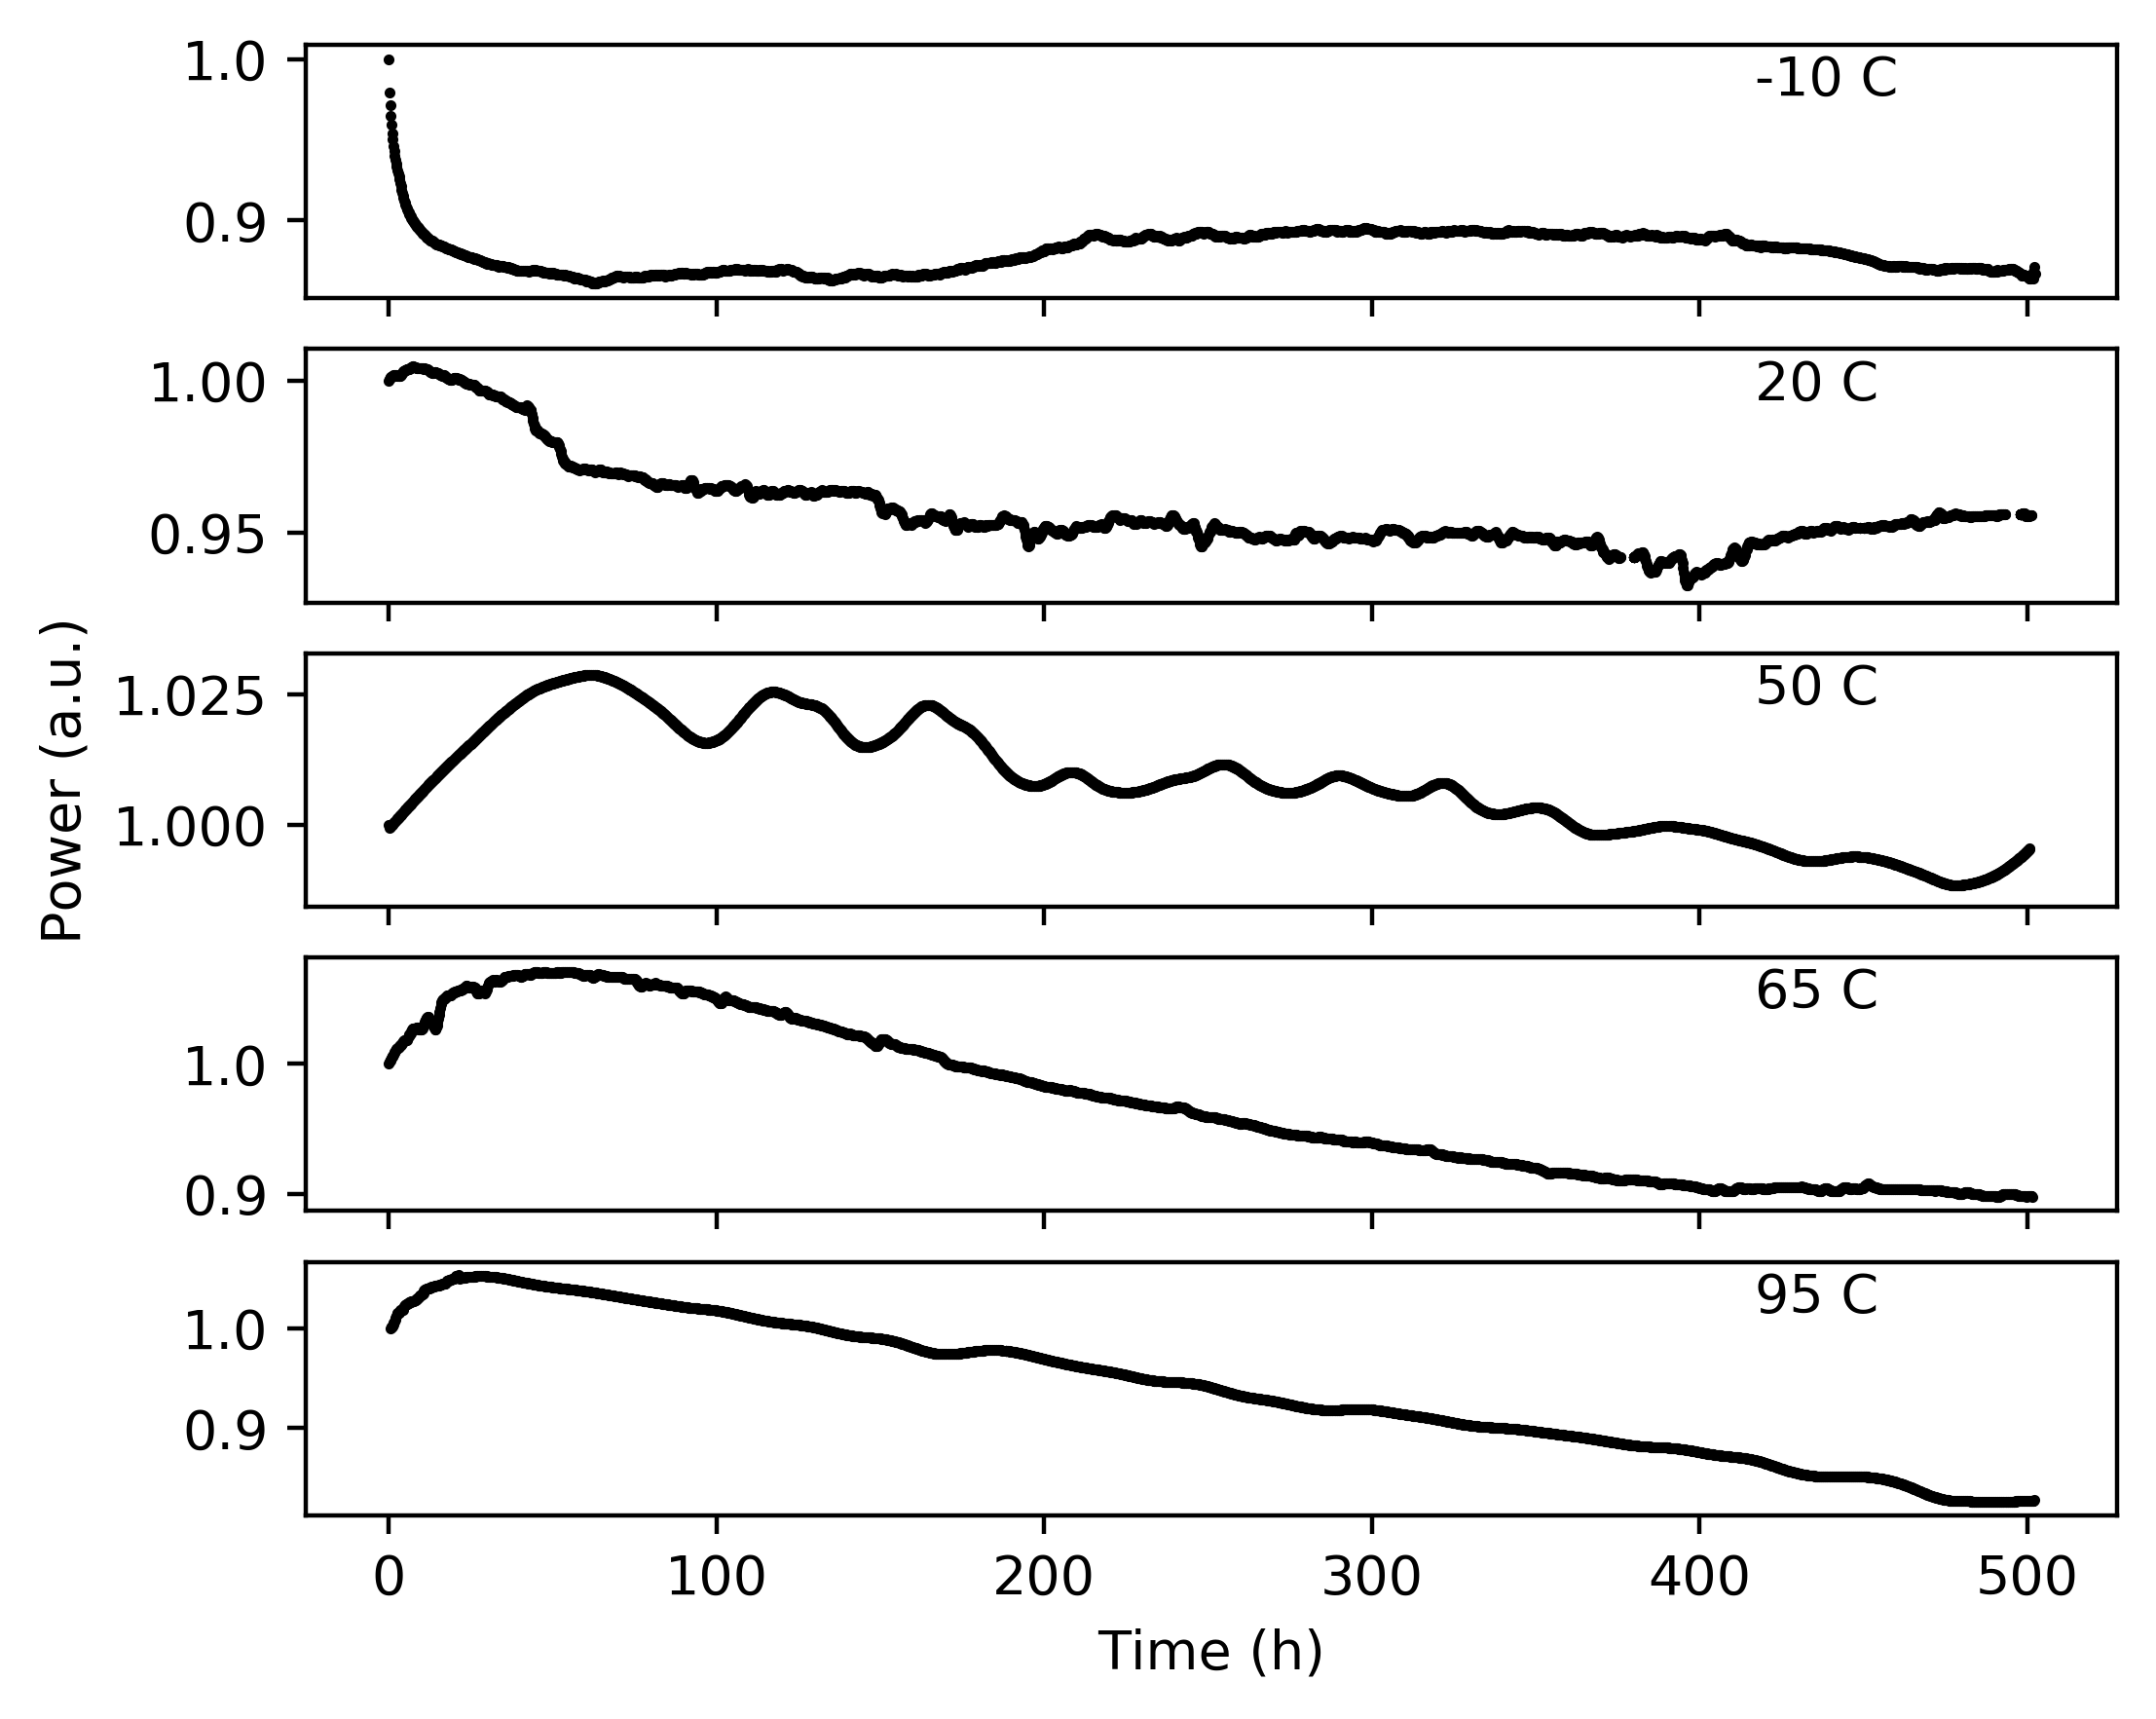

In [3]:
fig, axarr = plt.subplots(5, 1, sharex=True)
axes = axarr.flatten()
fig.dpi = 400
fig.set_size_inches((6, 5))

data_dir = '/.../' # SET FILE PATH HERE
filenum_2_df = {}
temps = [-10, 20, 50, 65, 95]
for file_num, df_fpath in enumerate(sorted(glob(data_dir + '*.txt'))):

    data_df = pd.read_csv(df_fpath, sep='\t', header=0, infer_datetime_format=True)
    data_df.t_delta = pd.to_timedelta(data_df.duration, unit='h')
    data_df = data_df.set_index(data_df.t_delta)
    data_df = data_df.resample('12T').bfill() 
    axes[file_num].scatter(data_df.duration, data_df.power / data_df.power[0], color='black', s=1)
    
    if file_num == 2:
        axes[file_num].set_ylabel('Power (a.u.)')
        
    axes[file_num].text(0.8, 0.8, '%s C' % temps[file_num], transform=axes[file_num].transAxes)
    
axes[file_num].set_xlabel('Time (h)')

# Data preprocessing

In [4]:
# Some helpful functions for data processing and augmentation

def preprocess_data(data_dir):
    
    data_dfs = []
    for file_num, data_fpath in enumerate(sorted(glob(data_dir + '*.txt'))):
        
        data_df = pd.read_csv(data_fpath, sep='\t', header=0, infer_datetime_format=True)
        data_df.t_delta = pd.to_timedelta(data_df.duration, unit='h')
        data_df = data_df.set_index(data_df.t_delta)
        
        data_df = data_df.resample('60T').bfill() 
        seconds = pd.to_timedelta(data_df.index - data_df.index[0]).astype('timedelta64[s]')
        data_df['duration'] = seconds / 3600
        
        data_df = data_df[data_df.duration >= 0.45]
        data_df = data_df[data_df.duration <= 500]
        data_df.power = data_df.power / data_df.power[0]
        
        if '10C' in data_fpath:
            data_df['temperature']=-10
        elif '20C' in data_fpath:
            data_df['temperature']=20
        elif '50C' in data_fpath:
            data_df['temperature']=50
        elif '65C' in data_fpath:
            data_df['temperature']=65
        elif '95C' in data_fpath:
            data_df['temperature']=95
            
        data_dfs.append(data_df)
    
    return data_dfs

def augment_data_vis(data_df_pairs):
    
    new_pwr_vectors = []
    new_pwr_vectors_lists = []
    
    new_vec_arrays = []
    new_vec_arrays_lists = []
    
    for pair_num, (key, value) in enumerate(data_df_pairs.items()):
        
        (pwr_df_1, pwr_df_2) = value
        num_steps = int((pwr_df_2.temperature[0] - pwr_df_1.temperature[0])/5)
        pwr_vec_1 = pwr_df_1.power.values
        pwr_vec_2 = pwr_df_2.power.values
        
        temp_vec_1 = pwr_df_1.temperature.values
        temp_vec_2 = pwr_df_2.temperature.values
            
        for weight_num, weight in enumerate(np.linspace(0, 1, num_steps + 1)):
            pwr_vec = weight * (pwr_vec_2 - pwr_vec_1) + pwr_vec_1
            temp_vec = weight * (temp_vec_2 - temp_vec_1) + temp_vec_1
            
            pwr_vec_list = list(np.round(pwr_vec, 4))
            temp_vec_list = list(np.round(temp_vec, 4))

            pwr_temp_vec = np.vstack([pwr_vec, temp_vec])
            
            if pwr_vec_list in new_pwr_vectors_lists:
                continue
            else:
                new_pwr_vectors_lists.append(pwr_vec_list)

                new_vec_arrays.append(pwr_temp_vec)

    return new_vec_arrays

def augment_data_lstm(data_df_pairs):
    
    new_pwr_vectors = []
    new_pwr_vectors_lists = []
    
    new_vec_arrays = []
    new_vec_arrays_lists = []
    
    stacked_vec_array = np.array([])
    
    hold_list = []
    temps = []
    for pair_num, (key, value) in enumerate(data_df_pairs.items()):
        
        (pwr_df_1, pwr_df_2) = value
        num_steps = int((pwr_df_2.temperature[0] - pwr_df_1.temperature[0])/5)
        pwr_vec_1 = pwr_df_1.power.values
        pwr_vec_2 = pwr_df_2.power.values
        
        temp_vec_1 = pwr_df_1.temperature.values
        temp_vec_2 = pwr_df_2.temperature.values
            
        for weight_num, weight in enumerate(np.linspace(0, 1, num_steps + 1)):
            pwr_vec = weight * (pwr_vec_2 - pwr_vec_1) + pwr_vec_1
            temp_vec = weight * (temp_vec_2 - temp_vec_1) + temp_vec_1
            
            pwr_vec_list = list(np.round(pwr_vec, 4))
            temp_vec_list = list(np.round(temp_vec, 4))

            pwr_vec = pwr_vec.reshape(-1, 1)
            temp_vec = temp_vec.reshape(-1, 1)
            pwr_temp_vec = np.hstack([pwr_vec, temp_vec])
            
            if weight == 0 or weight == 1:
                if temp_vec[0] not in temps:
                    hold_list.append(pwr_temp_vec)
                    temps.append(temp_vec[0])
                continue
                
            if pwr_vec_list in new_pwr_vectors_lists:
                continue
            else:
                new_pwr_vectors_lists.append(pwr_vec_list)

                new_vec_arrays.append(pwr_temp_vec)
                
                
            if stacked_vec_array.size == 0:
                stacked_vec_array = pwr_temp_vec.copy()
            else:
                stacked_vec_array = np.vstack([stacked_vec_array.copy(), pwr_temp_vec.copy()])

    return new_vec_arrays, hold_list

In [5]:
DATA_DIR = '/.../' # SET FILE PATH HERE
data_dfs = preprocess_data(DATA_DIR)
_neg10C, _20C, _50C, _65C, _95C = data_dfs

# Here we leave out the 50C data set when generating our augmented data -- we will use this data as our test set
inter_pairs =OrderedDict()
inter_pairs = {1: (_neg10C, _20C), 2: (_20C, _65C), 3: (_65C, _95C)}
augmented_vects = augment_data_vis(inter_pairs)

Text(0.5, 0, 'Power (norm.)')

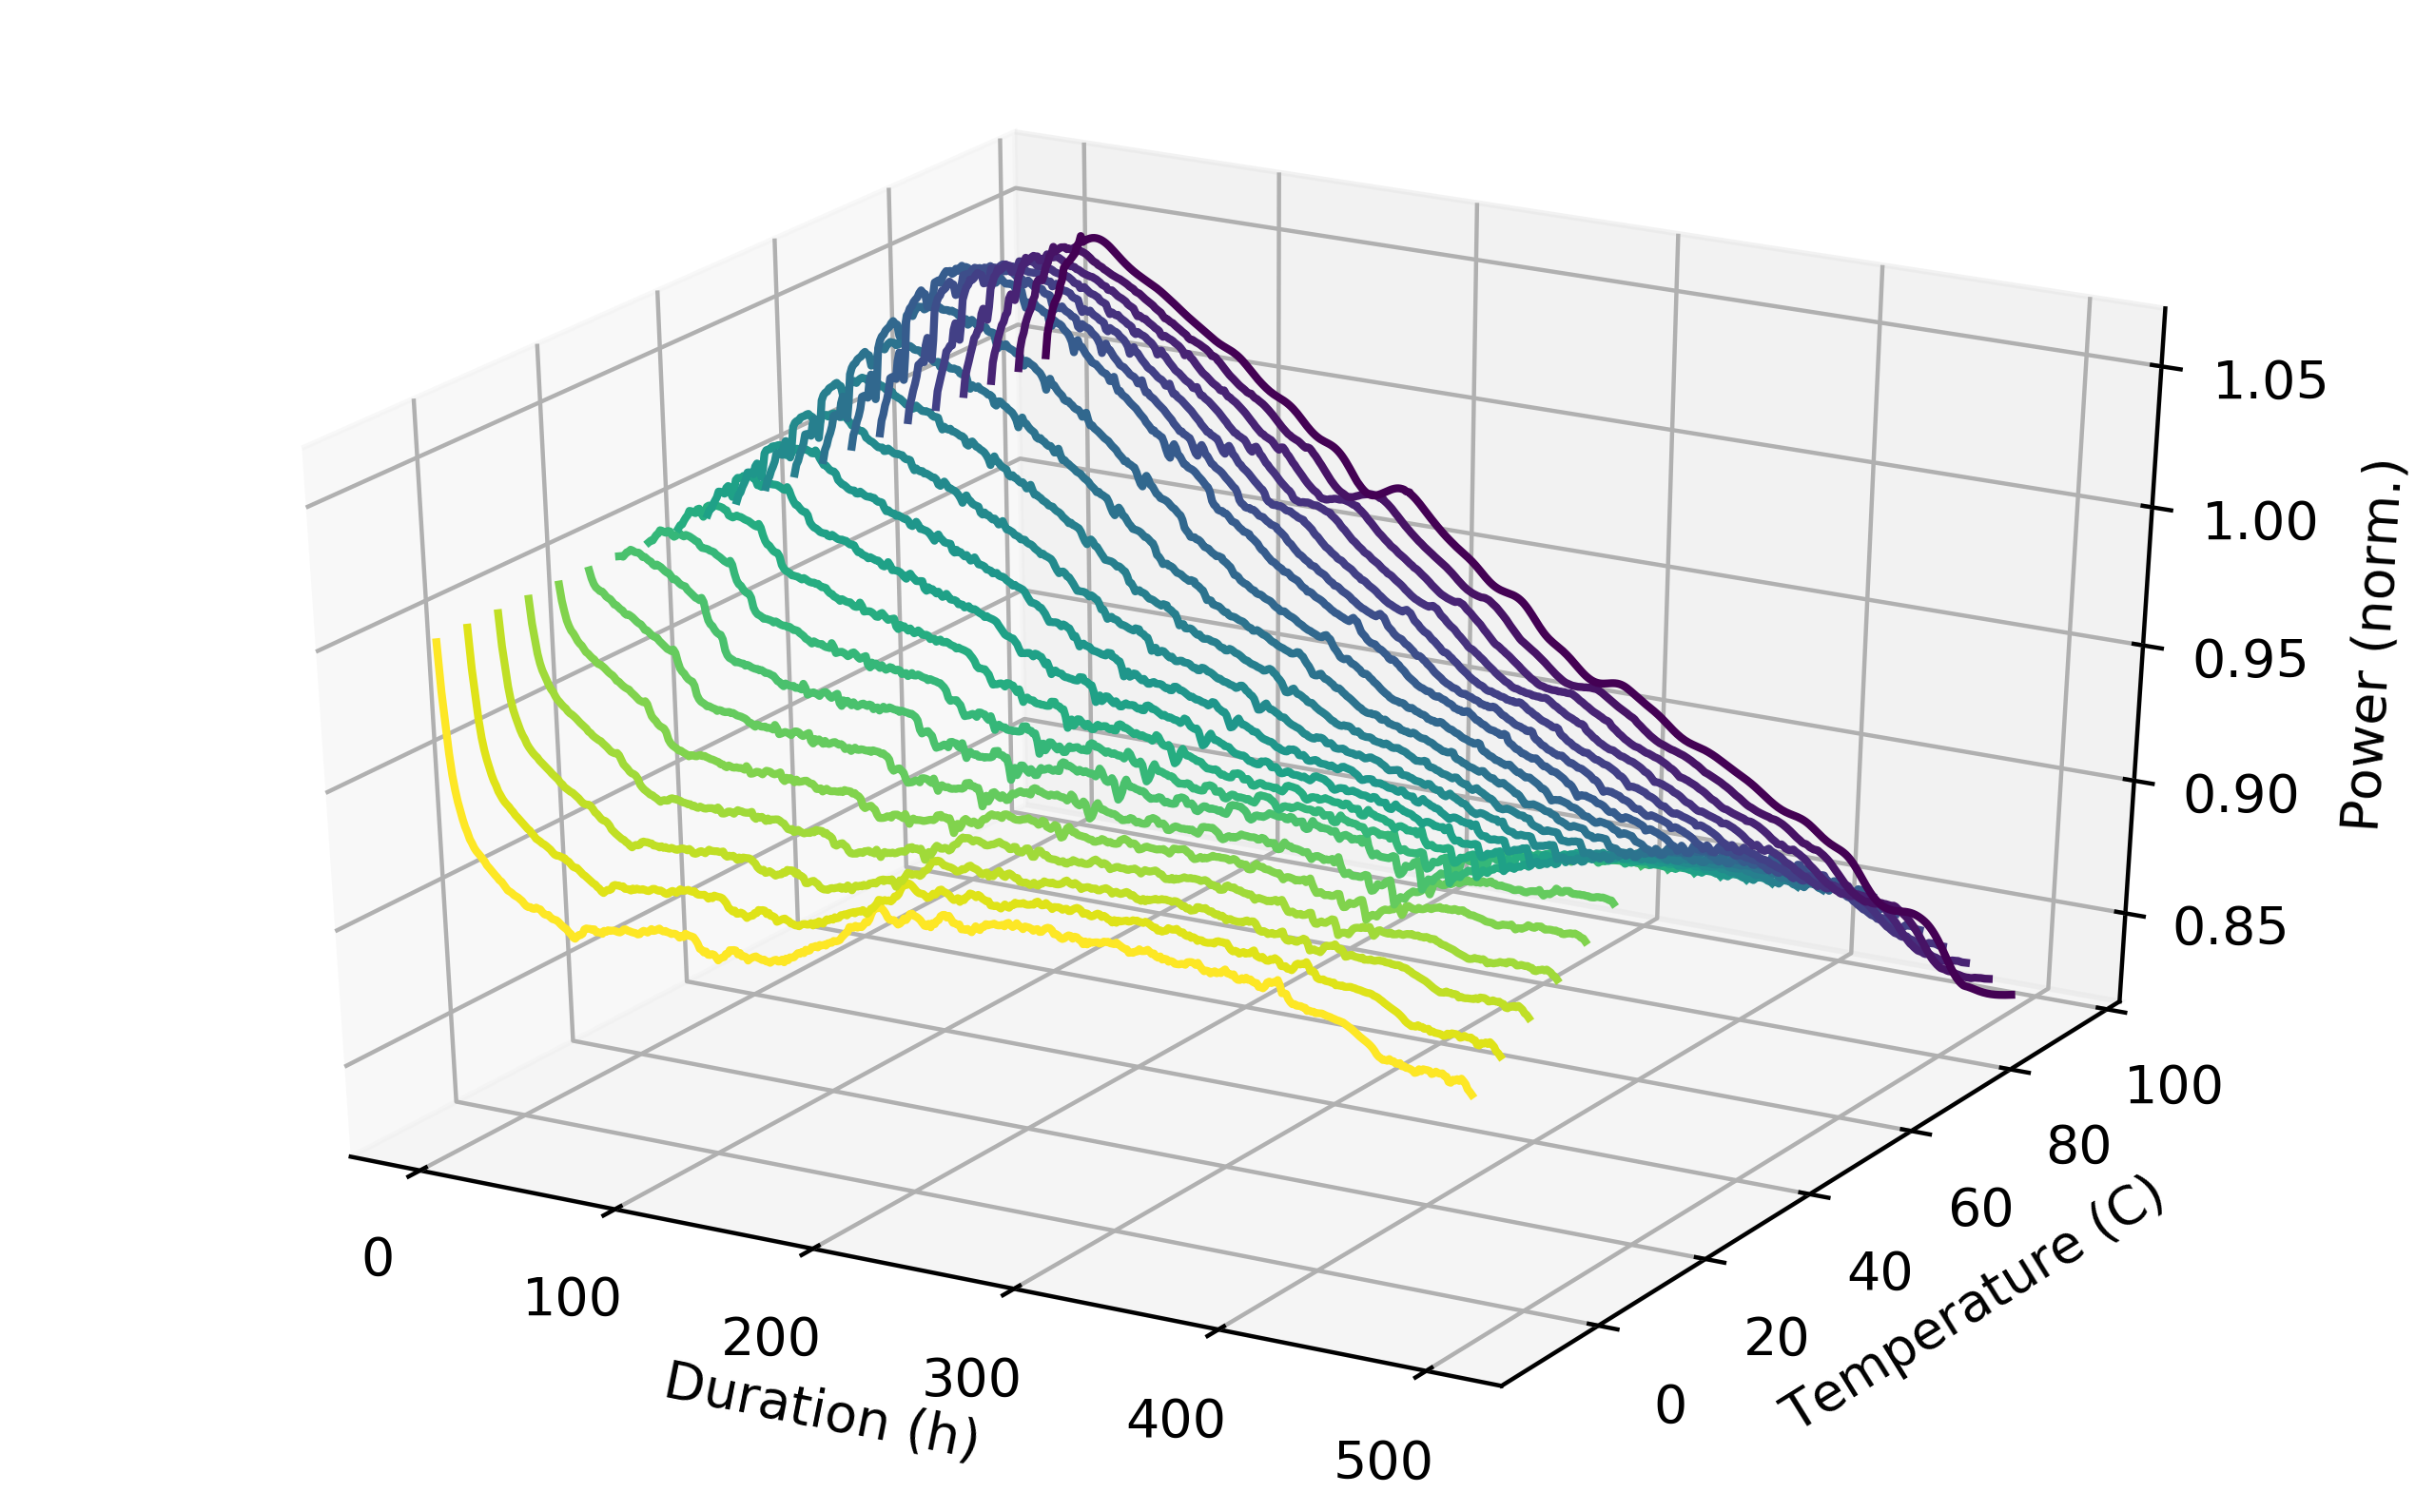

In [6]:
# Visualize the augmented data set

n = len(augmented_vects)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(dpi=400)
fig.set_size_inches(8, 5)
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.viridis_r(np.linspace(0,1,n))

data_resampled = data_df.resample('60T').bfill()
data_resampled = data_resampled[data_resampled.duration >= 0.4]
data_resampled = data_resampled[data_resampled.duration <= 500]
x = data_resampled['duration'].values

for i in range(0, len(augmented_vects)):

    a = augmented_vects[i]
    z = a[0,:]
    y = a[1,:]
    ax.plot(x, y, z, color=colors[i])

ax.set_xlabel('Duration (h)')
ax.set_ylabel('Temperature (C)')
ax.set_zlabel('Power (norm.)')

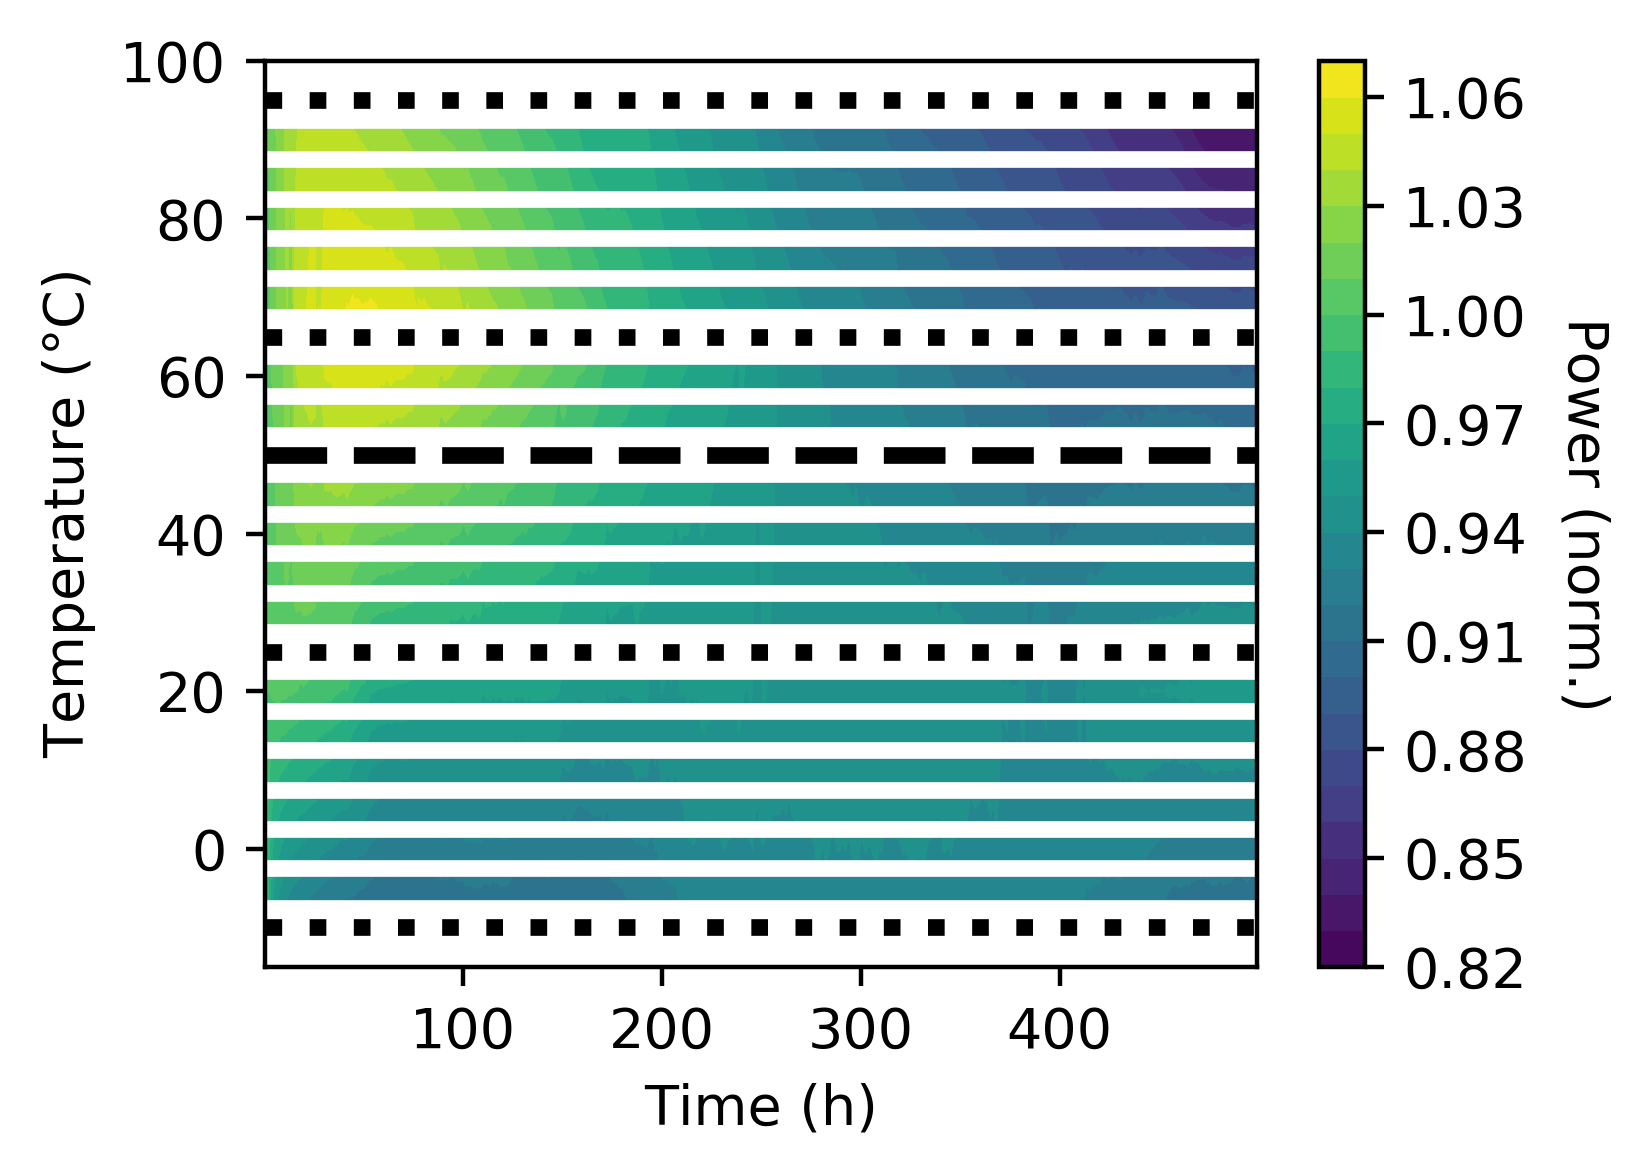

In [8]:
# Another way to visualize the augmented data, this time using a heat map

augmented_vects_2 = np.array(augmented_vects)
type(augmented_vects_2)
y = augmented_vects_2[:, 1, 0]
x = data_resampled['duration'].values
z = augmented_vects_2[:, 0, :]

fig = plt.figure(dpi=400)
fig.set_size_inches(4, 3)

plt.contourf(x, y, z, levels=25)
plt.xlabel('Time (h)')
plt.ylabel('Temperature ($\degree$C)')
plt.ylim([-15, 100])

cbar = plt.colorbar()
cbar.set_label('Power (norm.)', rotation=270)
cbar.ax.get_yaxis().labelpad = 15

ax = plt.gca()
aug_temp = -10
counter = 0
while aug_temp <= 95:
    ax.axhline(aug_temp, color='white', ls='-', lw=3)
    if counter == 0:
        aug_temp += 2.5
    else:
        aug_temp += 5
    counter += 1

temps = [-10, 25, 50, 65, 95]

for i, (temp) in enumerate(zip(temps)):
    ax.axhline(temp, color='white', ls='-', lw=4.5)
    if i == 2:
        ax.axhline(temp, color='black', ls='--', lw=3)
    else:
        ax.axhline(temp, color='black', ls=':', lw=3)


In [9]:
# Process data again, this time to use in LSTM training

DATA_DIR = '/.../' # SET FILE PATH HERE
data_dfs = preprocess_data(DATA_DIR)
_neg10C, _20C, _50C, _65C, _95C = data_dfs
inter_pairs =OrderedDict()
inter_pairs = {1: (_neg10C, _20C), 2: (_20C, _65C), 3: (_65C, _95C)}
augmented_vects, hold_list = augment_data_lstm(inter_pairs)
augmented_vects_2 = np.array(augmented_vects)
exps = np.array(hold_list)

np.random.seed(1119)
np.random.shuffle(augmented_vects_2)

augmented_vects_2 = np.vstack((augmented_vects_2, exps))
norm_aug_vects = augmented_vects_2.copy()

pwr = norm_aug_vects[:, :, 0].reshape(-1, 1)
temp = norm_aug_vects[:, :, 1].reshape(-1, 1)

pwr_scaler = MinMaxScaler(feature_range=(-1, 1))
temp_scaler = MinMaxScaler(feature_range=(-1, 1))

norm_pwr = pwr_scaler.fit_transform(pwr)
norm_temp = temp_scaler.fit_transform(temp)

aug_vects = np.hstack([pwr, temp])
norm_aug_vects = np.hstack([norm_pwr, norm_temp])

## Split into training and test sets

In [15]:
scaled = norm_aug_vects

data = scaled[:, [0, 1]] 
y = scaled[:, 0] 

# Split into train and validation sets
trainX, valX, trainy, valy = train_test_split(data, y, test_size=0.3, random_state=42, shuffle=False)

# Create overlapping windows of lagged values for training and testing datasets
timesteps = 20
batch_size = 500
train_generator = TimeseriesGenerator(trainX, trainy, length=timesteps, sampling_rate=1, batch_size=batch_size)
val_generator = TimeseriesGenerator(valX, valy, length=timesteps, sampling_rate=1, batch_size=batch_size)

train_X, train_y = train_generator[0]
val_X, val_y = val_generator[0]

train_samples = train_X.shape[0]*len(train_generator)
val_samples = val_X.shape[0]*len(val_generator)

print("Total Records (n): {}".format(data.shape[0]))
print("Total Records after adjusting for 24 hours: {}".format(len(data)))
print("Number of samples in training set (.7 * n): trainX = {}".format(trainX.shape[0]))
print("Number of samples in validation set (.3 * n): valX = {}".format(valX.shape[0]))
print("Size of individual batches: {}".format(val_X.shape[1]))
print("Number of total samples in training feature set: {}".format(train_samples))
print("Number of samples in validation feature set: {}".format(val_samples))

Total Records (n): 11000
Total Records after adjusting for 24 hours: 11000
Number of samples in training set (.7 * n): trainX = 7700
Number of samples in validation set (.3 * n): valX = 3300
Size of individual batches: 20
Number of total samples in training feature set: 8000
Number of samples in validation feature set: 3500


# Train the LSTM

In [13]:
# LSTM expects the input data in a specific 3D format of test sample size, time steps, no. of input features. 
# We had defined the time steps as n_lag variable in previous step.  
# Time steps are the past observations that the network will learn from (e.g. backpropagation through time).

# For details on what individual hyperparameters mean, see here: https://github.com/keras-team/keras/blob/master/keras/layers/recurrent.py#L2051

units = 5
num_epoch = 200
learning_rate = 0.00144

with mlflow.start_run(nested=True):

    model = Sequential()
    model.add(LSTM(units, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LeakyReLU(alpha=0.5)) 
    model.add(Dropout(0.1))
    model.add(Dense(1))

    adam = Adam(lr=learning_rate)
    # Stop training when a monitored quantity has stopped improving.
    callback = [EarlyStopping(monitor="loss", min_delta = 0.00001, patience = 50, mode = 'auto', restore_best_weights=True)]#, tensorboard] 

    # Using regression loss function 'Mean Absolute Percentage Error' and validation metric 'Normalized Root Mean Square Error'
    model.compile(loss='mean_absolute_percentage_error', optimizer=adam, metrics=[k_NRMSE])
    model.summary()
    
    # Fit network
    history = model.fit_generator(train_generator, \
                                  epochs=num_epoch, \
                                  validation_data=test_generator, \
                                  callbacks = callback, \
                                  verbose=2, \
                                  shuffle=False, \
                                  initial_epoch=0)

    mlflow.log_param("Units", units)
    mlflow.log_param("Epochs", num_epoch)
    mlflow.log_param("Learning Rate", learning_rate)
    mlflow.log_param("Lags cosidered", timesteps)

    # Return loss value and metric value
    score = model.evaluate_generator(test_generator, verbose=0)   
    mlflow.log_metric("Test Loss", score[0]) 
    mlflow.log_metric("mape", score[1])   
    mlflow.log_metric("Actual Epochs", len(history.history['loss']))
    mlflow.keras.log_model(model, "LSTM Model")

2021/03/22 14:44:26 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5)                 160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5)                 0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 166
Trainable params: 166
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
 - 2s - loss: 560.5198 - k_NRMSE: 13.7685 - val_loss: 174.7036 - val_k_NRMSE: 16.6190
Epoch 2/200
 - 0s - loss: 365.9760 - k_NRMSE: 12.1960 - val_loss: 154.0717 - val_k_NRMSE: 15.6320
Epoch 3/200
 - 0s - loss: 258.8250 - k_NRMSE: 11.3382 - va

Epoch 78/200
 - 0s - loss: 34.0728 - k_NRMSE: 1.8284 - val_loss: 13.0983 - val_k_NRMSE: 2.2134
Epoch 79/200
 - 1s - loss: 36.7968 - k_NRMSE: 1.8261 - val_loss: 14.9590 - val_k_NRMSE: 2.1751
Epoch 80/200
 - 0s - loss: 34.7455 - k_NRMSE: 1.7493 - val_loss: 12.8951 - val_k_NRMSE: 2.1784
Epoch 81/200
 - 1s - loss: 33.5287 - k_NRMSE: 1.7669 - val_loss: 14.2221 - val_k_NRMSE: 2.2231
Epoch 82/200
 - 0s - loss: 40.4770 - k_NRMSE: 1.7948 - val_loss: 13.1005 - val_k_NRMSE: 2.1890
Epoch 83/200
 - 0s - loss: 36.4952 - k_NRMSE: 1.7362 - val_loss: 15.9932 - val_k_NRMSE: 2.2918
Epoch 84/200
 - 1s - loss: 32.8165 - k_NRMSE: 1.7712 - val_loss: 16.5236 - val_k_NRMSE: 2.2482
Epoch 85/200
 - 0s - loss: 36.2960 - k_NRMSE: 1.7572 - val_loss: 14.0721 - val_k_NRMSE: 2.1619
Epoch 86/200
 - 0s - loss: 33.5337 - k_NRMSE: 1.7358 - val_loss: 14.3962 - val_k_NRMSE: 2.1871
Epoch 87/200
 - 0s - loss: 30.4582 - k_NRMSE: 1.7371 - val_loss: 15.7318 - val_k_NRMSE: 2.2432
Epoch 88/200
 - 0s - loss: 32.4508 - k_NRMSE: 1.70

Epoch 164/200
 - 0s - loss: 27.1640 - k_NRMSE: 1.5918 - val_loss: 20.3066 - val_k_NRMSE: 2.1678
Epoch 165/200
 - 0s - loss: 29.9103 - k_NRMSE: 1.6537 - val_loss: 15.1044 - val_k_NRMSE: 2.0660
Epoch 166/200
 - 0s - loss: 27.0733 - k_NRMSE: 1.6077 - val_loss: 14.4559 - val_k_NRMSE: 2.1333
Epoch 167/200
 - 0s - loss: 26.2123 - k_NRMSE: 1.6411 - val_loss: 16.3387 - val_k_NRMSE: 2.1969
Epoch 168/200
 - 0s - loss: 26.0299 - k_NRMSE: 1.6363 - val_loss: 17.7975 - val_k_NRMSE: 2.1464
Epoch 169/200
 - 0s - loss: 27.3219 - k_NRMSE: 1.6036 - val_loss: 16.1785 - val_k_NRMSE: 2.1371
Epoch 170/200
 - 0s - loss: 29.1819 - k_NRMSE: 1.6587 - val_loss: 15.2264 - val_k_NRMSE: 2.1805
Epoch 171/200
 - 0s - loss: 26.1048 - k_NRMSE: 1.6089 - val_loss: 16.5724 - val_k_NRMSE: 2.1666
Epoch 172/200
 - 0s - loss: 24.4053 - k_NRMSE: 1.6022 - val_loss: 19.6181 - val_k_NRMSE: 2.1727
Epoch 173/200
 - 0s - loss: 27.2170 - k_NRMSE: 1.5756 - val_loss: 16.1025 - val_k_NRMSE: 2.1232
Epoch 174/200
 - 0s - loss: 25.7255 - k_

# Visualize the results

In [16]:
# Make predictions
yhat_train_temp = model.predict_generator(train_generator)
yhat_test_temp = model.predict_generator(test_generator)

yhat_train = yhat_train_temp[:, 0]
yhat_test = yhat_test_temp[:, 0]

# training results
yhat_train_plot = np.empty(shape=[y.shape[0],])
yhat_train_plot[:] = np.nan
yhat_train.shape = yhat_train.shape[0]
yhat_train_plot.shape = yhat_train_plot.shape[0]
yhat_train_plot[timesteps:len(yhat_train)+timesteps] = yhat_train
  
#test results
yhat_test_plot = np.empty(shape=[y.shape[0],])
yhat_test_plot[:] = np.nan
yhat_test.shape = yhat_test.shape[0]
yhat_test_plot.shape = yhat_test_plot.shape[0]
yhat_test_plot[len(yhat_train)+(timesteps*2):len(y)] = yhat_test

yhat_train_plot = pwr_scaler.inverse_transform(yhat_train_plot.reshape(-1, 1))
yhat_test_plot = pwr_scaler.inverse_transform(yhat_test_plot.reshape(-1, 1))
y = scaled[:, 0]
y = pwr_scaler.inverse_transform(y.reshape(-1, 1))

NRMSE (%) for 50C prediction: 5.487798636697557


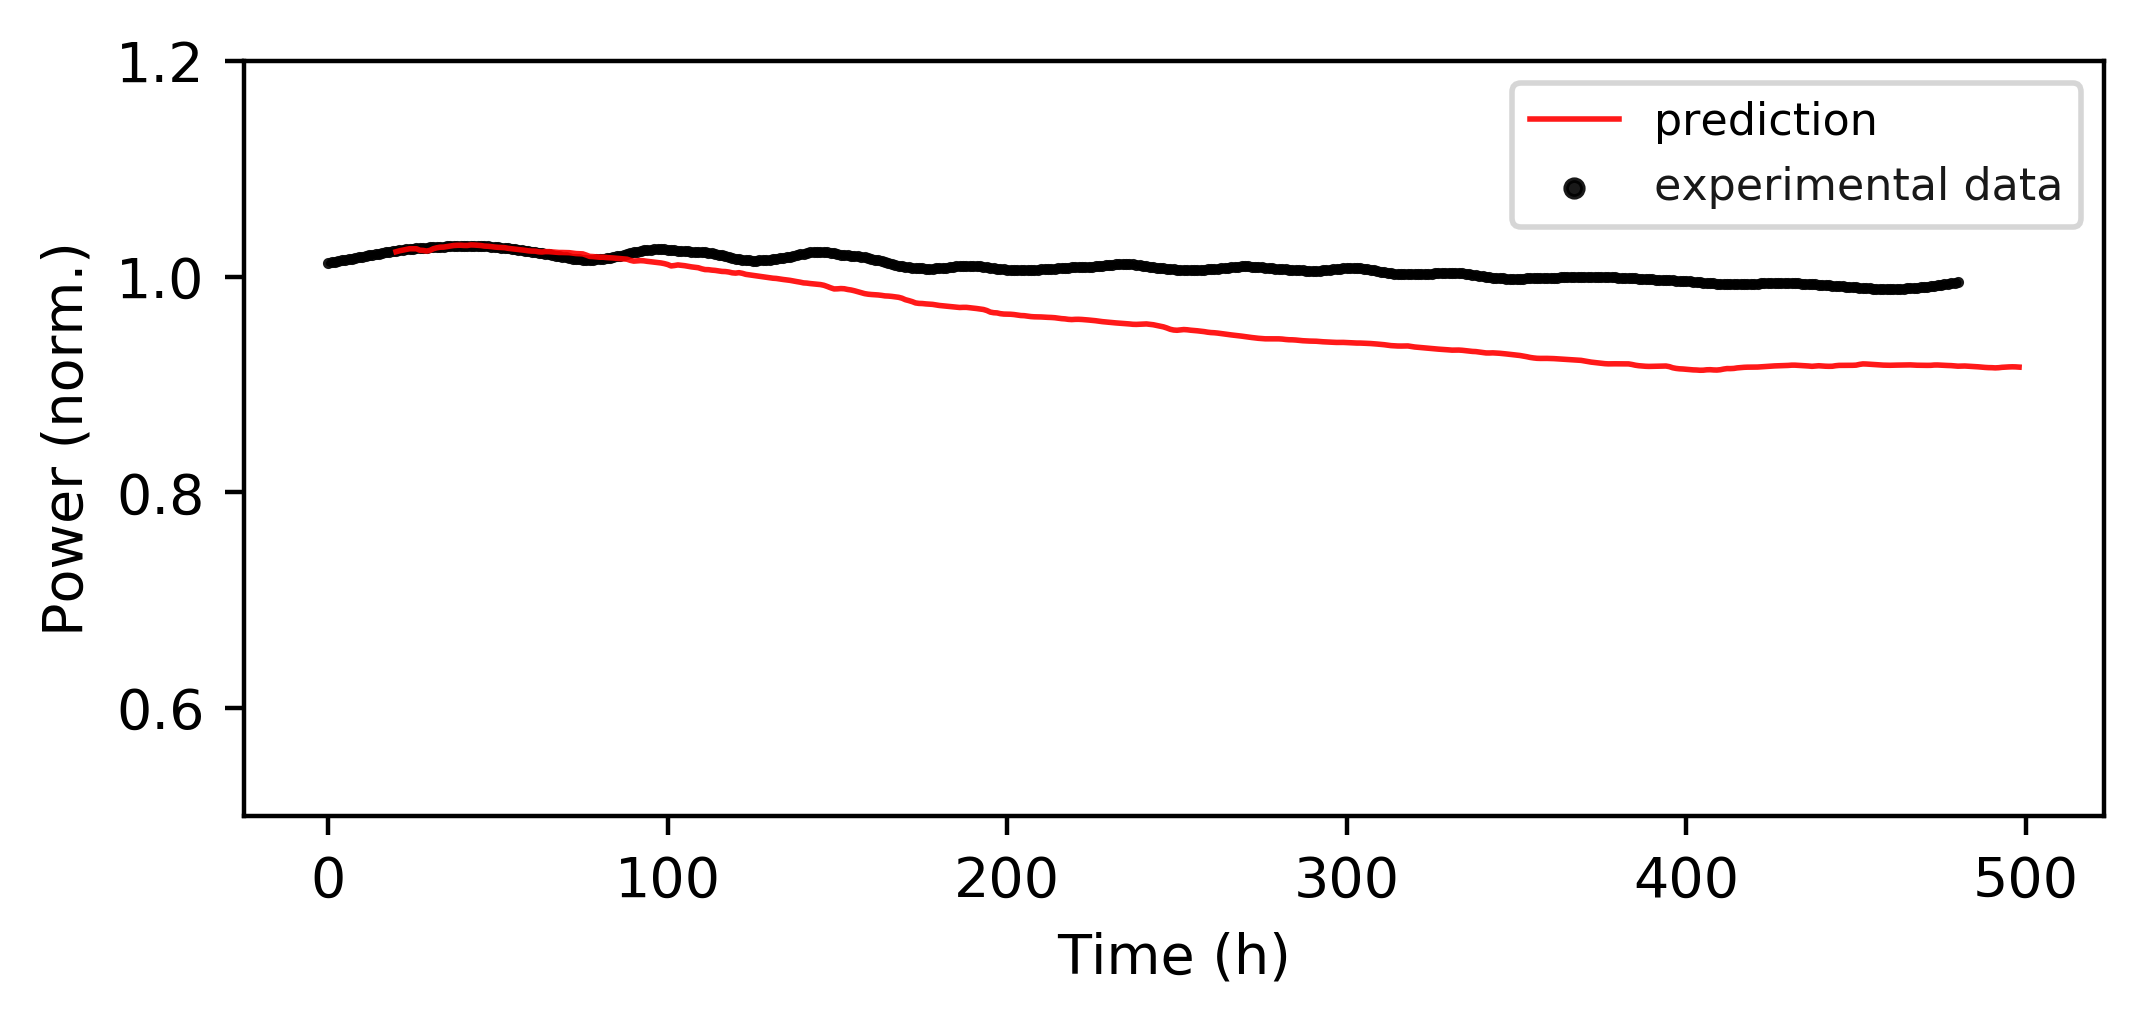

In [22]:
# load the test set experimental data
test_fp = '/Users/meghn/Desktop/Grad-School/LeiteLab/Data/ML_perspective_figures/holzhey_mapi_temp/02_50C.txt' # SET FILE PATH TO 50C DATA FILE HERE
test_df = pd.read_csv(test_fp, sep='\t', header=0, infer_datetime_format=True)
test_df.t_delta = pd.to_timedelta(test_df.duration, unit='h')
test_df = test_df.set_index(test_df.t_delta)
test_df = test_df.resample('60T').bfill() 
test_gen = TimeseriesGenerator(test_df.duration, test_df.power/test_df.power[0], length=20, sampling_rate=1, batch_size=500)
x_test, y_test = test_gen[0]

# Plot the experimental data and LSTM prediction 
fig = plt.figure()
# ax = plt.gca()
fig.dpi = 400
fig.set_size_inches((6, 2.5))

min_bound = np.argwhere(aug_vects[:, 1] == 50)[0][0]
max_bound = np.argwhere(aug_vects[:, 1] == 50)[-1][0]
plt.scatter(np.arange(0, 481), y_test, s=1, linewidth=1, alpha=0.9, label='experimental data', color='black')
plt.plot(np.arange(20, len(yhat_train_plot[min_bound:max_bound])), yhat_train_plot[min_bound+20:max_bound], marker='', linewidth=1, alpha=0.9, label='prediction', color='red')
print('NRMSE (%) for 50C prediction:', NRMSE(yhat_train_plot[min_bound+20:max_bound-18], y_test[20:])*100)

plt.ylabel('Power (norm.)')
plt.xlabel('Time (h)')
plt.ylim(0.5, 1.2)
temp = [50]
    
leg = plt.legend(frameon=True, fontsize=8, loc='upper right', markerscale=3)
for handle, text in zip(leg.legendHandles, leg.get_texts()):
    try:
        text.set_color(handle.get_facecolor()[0])
    except AttributeError:
        if i == 0:
            text.set_color('red')
        else:
            text.set_color('black')
        
    i += 1